In [30]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import RandomOverSampler, SMOTE

from plotly.offline import init_notebook_mode, iplot, plot
from plotly.subplots import make_subplots
import plotly.express as px
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


Hypothesis:  There exists a correlation between annual lobbying conttributions and the opioid prescribing rate in the US.

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(threshold=np.inf)

In [3]:
prescriber19 = pd.read_csv("inputs/Medicare_Part_D_Prescribers_by_Provider_2019.csv")
prescriber19.head()

,PRSCRBR_NPI,Prscrbr_Crdntls,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Tot_Clms,Opioid_Tot_Clms,Opioid_Prscrbr_Rate
0,1003000126,M.D.,MD,24.0,Internal Medicine,589,30.0,5.093379
1,1003000142,M.D.,OH,39.0,Anesthesiology,1092,464.0,42.490842
2,1003000167,DDS,NV,32.0,Dentist,73,NaN,NaN
3,1003000175,D.D.S.,CA,6.0,Dentist,21,0.0,0.000000
4,1003000282,FNP,TN,47.0,Nurse Practitioner,63,0.0,0.000000


In [4]:
prescriber18 = pd.read_csv("inputs/Medicare_Part_D_Prescribers_by_Provider_2018.csv")
prescriber18.head()

,PRSCRBR_NPI,Prscrbr_Crdntls,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Tot_Clms,Opioid_Tot_Clms,Opioid_Prscrbr_Rate
0,1003000126,M.D.,MD,24.0,Internal Medicine,492,13.0,2.642276
1,1003000142,M.D.,OH,39.0,Anesthesiology,1818,891.0,49.009901
2,1003000167,DDS,NV,32.0,Dentist,77,NaN,NaN
3,1003000282,FNP,TN,47.0,Nurse Practitioner,100,0.0,0.000000
4,1003000407,D.O.,PA,42.0,Family Practice,2766,22.0,0.795372


In [5]:
prescribers18 = prescriber18[prescriber18['Opioid_Prscrbr_Rate'].notna()]
prescribers18.head()

,PRSCRBR_NPI,Prscrbr_Crdntls,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Tot_Clms,Opioid_Tot_Clms,Opioid_Prscrbr_Rate
0,1003000126,M.D.,MD,24.0,Internal Medicine,492,13.0,2.642276
1,1003000142,M.D.,OH,39.0,Anesthesiology,1818,891.0,49.009901
3,1003000282,FNP,TN,47.0,Nurse Practitioner,100,0.0,0.000000
4,1003000407,D.O.,PA,42.0,Family Practice,2766,22.0,0.795372
6,1003000480,MD,CO,8.0,General Surgery,41,12.0,29.268293


Remove all rows that have a null value state or have a state outside of the US. 

In [6]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY','DC']

In [7]:
prescribers18 = prescribers18.loc[prescribers18.Prscrbr_State_Abrvtn.isin(states)]
prescribers18["year"] = 2018
mean = prescribers18["Opioid_Prscrbr_Rate"].mean()
prescribers18.head()
mean

8.965637539352429

In [8]:
categorical_features = ['Prscrbr_State_Abrvtn','Prscrbr_Type','year']
numerical_features = ['Tot_Clms', 'Opioid_Tot_Clms', 'Opioid_Prscrbr_Rate']
all_features = categorical_features + numerical_features

In [9]:
prescribers18['Sig_Prescriber'] = prescribers18.apply(lambda row : 1 if row['Opioid_Prscrbr_Rate'] < mean else 0, axis = 1)
prescribers18['Opioid_Prescriber'] = prescribers18.apply(lambda row : 1 if row['Opioid_Prscrbr_Rate'] >0 else 0, axis = 1)

In [10]:
prescribers18.head()

,PRSCRBR_NPI,Prscrbr_Crdntls,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Tot_Clms,Opioid_Tot_Clms,Opioid_Prscrbr_Rate,year,Sig_Prescriber,Opioid_Prescriber
0,1003000126,M.D.,MD,24.0,Internal Medicine,492,13.0,2.642276,2018,1,1
1,1003000142,M.D.,OH,39.0,Anesthesiology,1818,891.0,49.009901,2018,0,1
3,1003000282,FNP,TN,47.0,Nurse Practitioner,100,0.0,0.000000,2018,1,0
4,1003000407,D.O.,PA,42.0,Family Practice,2766,22.0,0.795372,2018,1,1
6,1003000480,MD,CO,8.0,General Surgery,41,12.0,29.268293,2018,0,1


Initial feature removal will include any prescriber identifying information and the brand name of the prescribed medicine. 

Loading all data of drug distribution

In [11]:
arcos18 = pd.read_excel("inputs/2018_arcos.xlsx",index_col=0)
arcos18.head()

,total_grams,year
state,,
AL,2594111.45,2018
AK,269803.91,2018
AS,2982282.90,2018
AR,1443421.60,2018
CA,10870450.41,2018


In [12]:
annual_dist18 = arcos18.groupby(['year'], as_index=False)['total_grams'].sum()
annual_dist18

,year,total_grams
0,2018,1.127219e+08


In [13]:
arcos19 = pd.read_excel("inputs/arcos_2019.xlsx",index_col=0)
arcos19.head()

,total_grams,year
state,,
AL,2298187.28,2019
AK,219535.91,2019
AS,2600083.33,2019
AR,1186899.81,2019
CA,9301016.07,2019


In [14]:

annual_dist19 = arcos19.groupby(['year'], as_index=False)['total_grams'].sum()
annual_dist19.T
annual_dist19

,year,total_grams
0,2019,1.106431e+08


In [15]:
annual_contribs = pd.concat([annual_dist18,annual_dist19])
annual_contribs.head()

,year,total_grams
0,2018,1.127219e+08
0,2019,1.106431e+08


In [16]:
lobbying1819 = pd.read_csv("inputs/2018-2019LobbyingContributions.csv", usecols=['report_year', 
      'contributor_employer',  'receipt_type', 'receipt_type_desc', 'contribution_receipt_amount',
       'contributor_aggregate_ytd', 'amendment_indicator',
       'amendment_indicator_desc'])
lobbying1819.head()

,report_year,contributor_employer,receipt_type,receipt_type_desc,contribution_receipt_amount,contributor_aggregate_ytd,amendment_indicator,amendment_indicator_desc
0,2018,PHRMA,15,CONTRIBUTION,-1100.00,100.00,A,ADD
1,2018,PHRMA,15,CONTRIBUTION,10.00,270.00,A,ADD
2,2018,PHRMA,15,CONTRIBUTION,10.83,205.77,A,ADD
3,2018,PHRMA,15,CONTRIBUTION,15.00,285.00,A,ADD
4,2018,PHRMA,15,CONTRIBUTION,15.00,285.00,A,ADD


In [17]:
annual_lobbying = lobbying1819.groupby(['report_year'], as_index=False)['contributor_aggregate_ytd'].sum()
annual_lobbying.T
annual_lobbying

,report_year,contributor_aggregate_ytd
0,2018,2.171886e+07
1,2019,2.379832e+07


In [18]:
presc_rates = pd.read_csv('inputs/Medicare_Part_D_Opioid_Prescribing_Rates_by_Geography_2019.csv')
presc_rates.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg
0,2019,NaN,Overall,1239380.0,803549.0,66138200.0,1.501140e+09,4.41,-1.32,-0.27
1,2019,NaN,Rural,134064.0,95576.0,11754049.0,2.602258e+08,4.52,-1.48,-0.29
2,2019,NaN,Urban,1103989.0,707114.0,54351962.0,1.240046e+09,4.38,-1.29,-0.28
3,2019,1.0,Overall,15575.0,9739.0,1814583.0,2.800821e+07,6.48,-1.40,-0.42
4,2019,2.0,Overall,2847.0,1935.0,80311.0,1.639104e+06,4.90,-2.01,-0.90


In [19]:
presc_rates = presc_rates[presc_rates['Prscrbr_Geo_Cd'].notna()]
presc_rates.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg
3,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.40,-0.42
4,2019,2.0,Overall,2847.0,1935.0,80311.0,1639104.0,4.90,-2.01,-0.90
5,2019,4.0,Overall,25876.0,16578.0,1359955.0,25693764.0,5.29,-1.79,-0.33
6,2019,5.0,Overall,9700.0,7258.0,998319.0,17894303.0,5.58,-1.08,-0.32
7,2019,6.0,Overall,129325.0,80941.0,5888034.0,138971644.0,4.24,-1.29,-0.35


In [20]:
state_code = prescriber18[['Prscrbr_State_Abrvtn','Prscrbr_State_FIPS']]
state_code.groupby('Prscrbr_State_FIPS')
state_code.head()

,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS
0,MD,24.0
1,OH,39.0
2,NV,32.0
3,TN,47.0
4,PA,42.0


In [21]:
presc_rates = pd.merge(presc_rates, state_code,left_on='Prscrbr_Geo_Cd',right_on='Prscrbr_State_FIPS')
presc_rates.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS
0,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0
1,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0
2,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0
3,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0
4,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0


In [22]:
# presc_rates = pd.merge(presc_rates, )

Adding distribution by grams.

In [23]:
rates_dist = pd.merge(presc_rates, annual_contribs, how='outer',left_on='Year',right_on='year')
rates_dist.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,year,total_grams
0,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08
1,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08
2,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08
3,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08
4,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08


In [24]:
presc_rate_w_lobbying = pd.merge(rates_dist, annual_lobbying, how='outer',left_on='Year',right_on='report_year')
presc_rate_w_lobbying.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
0,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08,2019.0,2.379832e+07
1,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08,2019.0,2.379832e+07
2,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08,2019.0,2.379832e+07
3,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08,2019.0,2.379832e+07
4,2019,1.0,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.4,-0.42,AL,1.0,2019.0,1.106431e+08,2019.0,2.379832e+07


In [25]:
#presc_rate_w_lobbying = presc_rate_w_lobbying.drop_duplicates()

In [26]:
presc_rate_w_lobbying.describe()

,Year,Prscrbr_Geo_Cd,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
count,25273416.0,2.527342e+07,2.527342e+07,2.527342e+07,2.527342e+07,2.527342e+07,2.520416e+07,7.199750e+06,2.159925e+07,2.527342e+07,7220976.0,7.220976e+06,7220976.0,7.220976e+06
mean,2016.0,2.828587e+01,3.099043e+04,2.163411e+04,1.885277e+06,3.838541e+07,5.293697e+00,-1.275103e+00,-2.432637e-01,2.828587e+01,2018.5,1.116825e+08,2018.5,2.275859e+07
std,2.0,1.608508e+01,3.403990e+04,2.301945e+04,1.900685e+06,3.959041e+07,1.281006e+00,4.775517e-01,1.727441e-01,1.608508e+01,0.5,1.039390e+06,0.5,1.039730e+06
min,2013.0,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.200000e-01,-2.710000e+00,-1.340000e+00,1.000000e+00,2018.0,1.106431e+08,2018.0,2.171886e+07
25%,2014.0,1.300000e+01,4.488000e+03,3.365000e+03,4.421420e+05,8.346546e+06,4.480000e+00,-1.610000e+00,-3.500000e-01,1.300000e+01,2018.0,1.106431e+08,2018.0,2.171886e+07
50%,2016.0,2.800000e+01,1.834200e+04,1.350800e+04,1.215264e+06,2.188297e+07,5.250000e+00,-1.230000e+00,-2.300000e-01,2.800000e+01,2018.5,1.116825e+08,2018.5,2.275859e+07
75%,2018.0,4.100000e+01,4.537600e+04,3.274200e+04,2.716388e+06,5.909813e+07,6.100000e+00,-9.600000e-01,-1.300000e-01,4.100000e+01,2019.0,1.127219e+08,2019.0,2.379832e+07
max,2019.0,7.800000e+01,1.293250e+05,8.379400e+04,7.423383e+06,1.393862e+08,8.370000e+00,9.300000e-01,5.800000e-01,7.800000e+01,2019.0,1.127219e+08,2019.0,2.379832e+07


Checking for feature correlation.  As a rule of thumb, correlations with an absolute value of 0.8 or more are strongly correlated; an absolute value between 0.6 and 0.8 indicates moderate correlation.

In [27]:
presc_rate_w_lobbying.corr(method="spearman")

,Year,Prscrbr_Geo_Cd,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
Year,1.000000e+00,9.661895e-18,0.046778,-0.009448,-0.063370,0.025673,-0.405395,-0.232961,-0.455243,9.661895e-18,1.000000e+00,-1.000000e+00,1.000000e+00,1.000000e+00
Prscrbr_Geo_Cd,9.661895e-18,1.000000e+00,-0.037978,-0.029266,-0.066808,-0.040589,-0.115203,-0.158139,-0.039657,1.000000e+00,5.895801e-18,-5.895801e-18,5.895801e-18,5.895801e-18
Tot_Prscrbrs,4.677850e-02,-3.797770e-02,1.000000,0.995935,0.949571,0.975457,-0.249709,0.311996,0.116698,-3.797770e-02,1.991230e-02,-1.991230e-02,1.991230e-02,1.991230e-02
Tot_Opioid_Prscrbrs,-9.447882e-03,-2.926634e-02,0.995935,1.000000,0.959651,0.974016,-0.203476,0.295712,0.131714,-2.926634e-02,-1.343514e-02,1.343514e-02,-1.343514e-02,-1.343514e-02
Tot_Opioid_Clms,-6.337046e-02,-6.680758e-02,0.949571,0.959651,1.000000,0.974692,-0.048256,0.287036,0.130874,-6.680758e-02,-3.664617e-02,3.664617e-02,-3.664617e-02,-3.664617e-02
Tot_Clms,2.567290e-02,-4.058907e-02,0.975457,0.974016,0.974692,1.000000,-0.239608,0.348986,0.140334,-4.058907e-02,-4.552673e-03,4.552673e-03,-4.552673e-03,-4.552673e-03
Opioid_Prscrbng_Rate,-4.053948e-01,-1.152033e-01,-0.249709,-0.203476,-0.048256,-0.239608,1.000000,-0.287940,-0.046617,-1.152033e-01,-1.428747e-01,1.428747e-01,-1.428747e-01,-1.428747e-01
Opioid_Prscrbng_Rate_5Y_Chg,-2.329608e-01,-1.581387e-01,0.311996,0.295712,0.287036,0.348986,-0.287940,1.000000,0.454251,-1.581387e-01,-2.329608e-01,2.329608e-01,-2.329608e-01,-2.329608e-01
Opioid_Prscrbng_Rate_1Y_Chg,-4.552433e-01,-3.965715e-02,0.116698,0.131714,0.130874,0.140334,-0.046617,0.454251,1.000000,-3.965715e-02,2.919276e-01,-2.919276e-01,2.919276e-01,2.919276e-01
Prscrbr_State_FIPS,9.661895e-18,1.000000e+00,-0.037978,-0.029266,-0.066808,-0.040589,-0.115203,-0.158139,-0.039657,1.000000e+00,5.895801e-18,-5.895801e-18,5.895801e-18,5.895801e-18


Columns to be removed due to correlations found above and duplicate features.

In [28]:
to_remove = ['Tot_Prscrbrs','Prscrbr_State_FIPS','Prscrbr_Geo_Cd', 'Tot_Opioid_Clms','report_year','year']

Split data into a training set and a test set.

In [31]:
# split data
train_set,test_set = train_test_split(presc_rate_w_lobbying,test_size = 0.2,random_state = 42)

In [32]:
train_set = train_set.drop_duplicates()
train_set = train_set[train_set['report_year'].notna()]
train_set = train_set[train_set.Tot_Clms > 0]
# train_set.drop('report_year',axis=1, inplace=True)
# train_set.drop('year',axis=1, inplace=True)
for each in to_remove:
    train_set.drop(each,axis=1, inplace=True)

In [33]:
train_set.head(20)

,Year,Breakout,Tot_Opioid_Prscrbrs,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
4034218,2018,Urban,79639.0,132936548.0,4.49,-0.91,-0.29,CA,1.127219e+08,2.171886e+07
3910334,2018,Rural,3332.0,6413187.0,6.73,-1.64,-0.52,CA,1.127219e+08,2.171886e+07
2623679,2019,Urban,27787.0,50103515.0,4.04,-1.74,-0.30,OH,1.106431e+08,2.379832e+07
4780168,2018,Overall,16463.0,34249339.0,5.38,-1.58,-0.45,IN,1.127219e+08,2.171886e+07
4601198,2018,Overall,2871.0,4035698.0,3.61,-0.34,-0.25,HI,1.127219e+08,2.171886e+07
2217973,2019,Rural,3159.0,8597542.0,3.54,-0.60,-0.09,NY,1.106431e+08,2.379832e+07
3427,2019,Overall,9739.0,28008206.0,6.48,-1.40,-0.42,AL,1.106431e+08,2.379832e+07
608181,2019,Overall,10751.0,16874265.0,3.43,-1.17,-0.13,CT,1.106431e+08,2.379832e+07
1605035,2019,Overall,30583.0,50868312.0,5.10,-2.35,-0.45,MI,1.106431e+08,2.379832e+07
58020,2019,Overall,16578.0,25693764.0,5.29,-1.79,-0.33,AZ,1.106431e+08,2.379832e+07


In [34]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1520 entries, 4034218 to 2605214
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Year                         1520 non-null   int64  
 1   Breakout                     1520 non-null   object 
 2   Tot_Opioid_Prscrbrs          1520 non-null   float64
 3   Tot_Clms                     1520 non-null   float64
 4   Opioid_Prscrbng_Rate         1520 non-null   float64
 5   Opioid_Prscrbng_Rate_5Y_Chg  1520 non-null   float64
 6   Opioid_Prscrbng_Rate_1Y_Chg  1520 non-null   float64
 7   Prscrbr_State_Abrvtn         1520 non-null   object 
 8   total_grams                  1520 non-null   float64
 9   contributor_aggregate_ytd    1520 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 130.6+ KB


In [35]:
test_set.columns

Index(['Year', 'Prscrbr_Geo_Cd', 'Breakout', 'Tot_Prscrbrs',
       'Tot_Opioid_Prscrbrs', 'Tot_Opioid_Clms', 'Tot_Clms',
       'Opioid_Prscrbng_Rate', 'Opioid_Prscrbng_Rate_5Y_Chg',
       'Opioid_Prscrbng_Rate_1Y_Chg', 'Prscrbr_State_Abrvtn',
       'Prscrbr_State_FIPS', 'year', 'total_grams', 'report_year',
       'contributor_aggregate_ytd'],
      dtype='object')

In [36]:
categorical_features = ['Year','Breakout','Prscrbr_State_Abrvtn']

In [37]:
categorical_features

['Year', 'Breakout', 'Prscrbr_State_Abrvtn']

In [38]:
category_values = {}

for feature in categorical_features:
    category_values[feature] = list(train_set[feature].value_counts().index)

lst1 = train_set['Breakout'].unique().tolist()
lst2 = train_set['Prscrbr_State_Abrvtn'].unique().tolist()
categorical_features = categorical_features + lst1 + lst2


print(category_values)

{'Year': [2019, 2018], 'Breakout': ['Urban', 'Overall', 'Rural'], 'Prscrbr_State_Abrvtn': ['ZZ', 'AA', 'CA', 'TN', 'MD', 'IL', 'TX', 'XX', 'AL', 'GA', 'MA', 'WA', 'FL', 'NM', 'NY', 'NC', 'MI', 'KY', 'NJ', 'OH', 'IN', 'DC', 'PA', 'MN', 'MO', 'ME', 'OR', 'NE', 'HI', 'VA', 'AZ', 'LA', 'KS', 'NV', 'VT', 'MS', 'WV', 'AR', 'PR', 'MT', 'CT', 'ID', 'SC', 'ND', 'UT', 'AK', 'NH', 'CO', 'WI', 'AE', 'RI', 'SD', 'DE', 'AP', 'GU', 'VI', 'WY', 'IA', 'OK', 'AS']}


In [39]:
def pre_process_data(df, categoical_values):
    new_df = df.copy(deep=True)
    for feature in df.columns:
        if feature in categorical_features:
            new_df[feature] = pd.factorize(df[feature], sort = True)[0]
    return new_df
    



In [40]:
processed_train = pre_process_data(train_set, category_values)
processed_train.head()

,Year,Breakout,Tot_Opioid_Prscrbrs,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
4034218,0,2,79639.0,132936548.0,4.49,-0.91,-0.29,8,1.127219e+08,2.171886e+07
3910334,0,1,3332.0,6413187.0,6.73,-1.64,-0.52,8,1.127219e+08,2.171886e+07
2623679,1,2,27787.0,50103515.0,4.04,-1.74,-0.30,40,1.106431e+08,2.379832e+07
4780168,0,0,16463.0,34249339.0,5.38,-1.58,-0.45,20,1.127219e+08,2.171886e+07
4601198,0,0,2871.0,4035698.0,3.61,-0.34,-0.25,16,1.127219e+08,2.171886e+07


In [41]:
final_features = ['Year', 'Breakout', 'Tot_Opioid_Prscrbrs', 'Tot_Clms',
         'Opioid_Prscrbng_Rate_5Y_Chg','Opioid_Prscrbng_Rate_1Y_Chg', 'Prscrbr_State_Abrvtn', 'total_grams',
       'contributor_aggregate_ytd']
label = 'Opioid_Prscrbng_Rate'

In [42]:
x_train = processed_train[final_features]
y_train = processed_train[label]


In [43]:
x_train.head()

,Year,Breakout,Tot_Opioid_Prscrbrs,Tot_Clms,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
4034218,0,2,79639.0,132936548.0,-0.91,-0.29,8,1.127219e+08,2.171886e+07
3910334,0,1,3332.0,6413187.0,-1.64,-0.52,8,1.127219e+08,2.171886e+07
2623679,1,2,27787.0,50103515.0,-1.74,-0.30,40,1.106431e+08,2.379832e+07
4780168,0,0,16463.0,34249339.0,-1.58,-0.45,20,1.127219e+08,2.171886e+07
4601198,0,0,2871.0,4035698.0,-0.34,-0.25,16,1.127219e+08,2.171886e+07


In [44]:
processed_test = pre_process_data(test_set, category_values)
processed_test.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
22150784,0,6.0,2,105103.0,79135.0,6763821.0,125211671.0,5.40,NaN,NaN,8,6.0,NaN,NaN,NaN,NaN
9953596,4,42.0,0,57584.0,37743.0,3289886.0,75707853.0,4.35,NaN,-0.38,43,42.0,NaN,NaN,NaN,NaN
17680292,2,48.0,2,63031.0,47450.0,4301134.0,75562569.0,5.69,NaN,-0.43,49,48.0,NaN,NaN,NaN,NaN
16725752,2,36.0,2,84483.0,52886.0,2603889.0,86189804.0,3.02,NaN,0.04,39,36.0,NaN,NaN,NaN,NaN
22356055,0,12.0,0,61006.0,46454.0,5292592.0,100515166.0,5.27,NaN,NaN,13,12.0,NaN,NaN,NaN,NaN


In [45]:
for each in processed_test.isna().columns:
    if each == 'report_year':
        # code it with 5 meaning not available
        processed_test[each] = 5
    elif each == 'Breakout':
        processed_test[each] == 99
    else:
        processed_test[each] = processed_test[each].fillna(0)

In [46]:
processed_test.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
22150784,0,6.0,2,105103.0,79135.0,6763821.0,125211671.0,5.40,0.0,0.00,8,6.0,0.0,0.0,5,0.0
9953596,4,42.0,0,57584.0,37743.0,3289886.0,75707853.0,4.35,0.0,-0.38,43,42.0,0.0,0.0,5,0.0
17680292,2,48.0,2,63031.0,47450.0,4301134.0,75562569.0,5.69,0.0,-0.43,49,48.0,0.0,0.0,5,0.0
16725752,2,36.0,2,84483.0,52886.0,2603889.0,86189804.0,3.02,0.0,0.04,39,36.0,0.0,0.0,5,0.0
22356055,0,12.0,0,61006.0,46454.0,5292592.0,100515166.0,5.27,0.0,0.00,13,12.0,0.0,0.0,5,0.0


In [47]:
x_test = processed_test[final_features]
y_test = processed_test[label]

In [48]:
x_test.head()

,Year,Breakout,Tot_Opioid_Prscrbrs,Tot_Clms,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
22150784,0,2,79135.0,125211671.0,0.0,0.00,8,0.0,0.0
9953596,4,0,37743.0,75707853.0,0.0,-0.38,43,0.0,0.0
17680292,2,2,47450.0,75562569.0,0.0,-0.43,49,0.0,0.0
16725752,2,2,52886.0,86189804.0,0.0,0.04,39,0.0,0.0
22356055,0,0,46454.0,100515166.0,0.0,0.00,13,0.0,0.0


In [49]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [50]:
y_pred = regressor.predict(x_test)

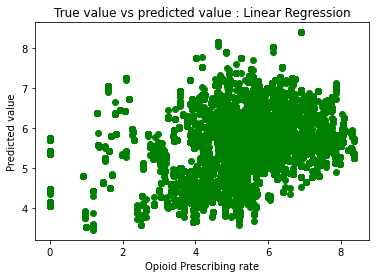

In [51]:
plt.scatter(y_test, y_pred, c = 'green')
plt.xlabel("Opioid Prescribing rate")
plt.ylabel("Predicted value")
plt.title("True value vs predicted value : Linear Regression")
plt.show()

In [52]:

mse = mean_squared_error(y_test, y_pred)
print("Mean Square Error : ", mse)

Mean Square Error :  1.607125647974277


Removing some more features that might be directly correlated to the value we want to predict.

In [57]:
processed_train2 = pre_process_data(train_set, category_values)
processed_train2.head()

,Year,Breakout,Tot_Opioid_Prscrbrs,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
4034218,0,2,79639.0,132936548.0,4.49,-0.91,-0.29,8,1.127219e+08,2.171886e+07
3910334,0,1,3332.0,6413187.0,6.73,-1.64,-0.52,8,1.127219e+08,2.171886e+07
2623679,1,2,27787.0,50103515.0,4.04,-1.74,-0.30,40,1.106431e+08,2.379832e+07
4780168,0,0,16463.0,34249339.0,5.38,-1.58,-0.45,20,1.127219e+08,2.171886e+07
4601198,0,0,2871.0,4035698.0,3.61,-0.34,-0.25,16,1.127219e+08,2.171886e+07


In [93]:
final_features2 = ['Year', 'Opioid_Prscrbng_Rate_5Y_Chg',
       'Opioid_Prscrbng_Rate_1Y_Chg', 'total_grams','Tot_Clms',
       'contributor_aggregate_ytd']
label = 'Opioid_Prscrbng_Rate'

In [94]:
x_train2 = processed_train[final_features2]
y_train2 = processed_train[label]

In [95]:
x_train2.head()

,Year,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,total_grams,Tot_Clms,contributor_aggregate_ytd
4034218,0,-0.91,-0.29,1.127219e+08,132936548.0,2.171886e+07
3910334,0,-1.64,-0.52,1.127219e+08,6413187.0,2.171886e+07
2623679,1,-1.74,-0.30,1.106431e+08,50103515.0,2.379832e+07
4780168,0,-1.58,-0.45,1.127219e+08,34249339.0,2.171886e+07
4601198,0,-0.34,-0.25,1.127219e+08,4035698.0,2.171886e+07


In [96]:
processed_test = pre_process_data(test_set, category_values)
processed_test.head()

,Year,Prscrbr_Geo_Cd,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,year,total_grams,report_year,contributor_aggregate_ytd
22150784,0,6.0,2,105103.0,79135.0,6763821.0,125211671.0,5.40,NaN,NaN,8,6.0,NaN,NaN,NaN,NaN
9953596,4,42.0,0,57584.0,37743.0,3289886.0,75707853.0,4.35,NaN,-0.38,43,42.0,NaN,NaN,NaN,NaN
17680292,2,48.0,2,63031.0,47450.0,4301134.0,75562569.0,5.69,NaN,-0.43,49,48.0,NaN,NaN,NaN,NaN
16725752,2,36.0,2,84483.0,52886.0,2603889.0,86189804.0,3.02,NaN,0.04,39,36.0,NaN,NaN,NaN,NaN
22356055,0,12.0,0,61006.0,46454.0,5292592.0,100515166.0,5.27,NaN,NaN,13,12.0,NaN,NaN,NaN,NaN


In [97]:

for each in processed_test.isna().columns:
    if each == 'report_year':
        # code it with 5 meaning not available
        processed_test[each] = 5
    elif each == 'Breakout':
        processed_test[each] == 99
    else:
        processed_test[each] = processed_test[each].fillna(0)
        
x_test2 = processed_test[final_features2]
y_test2 = processed_test[label]
x_test2.head()

,Year,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,total_grams,Tot_Clms,contributor_aggregate_ytd
22150784,0,0.0,0.00,0.0,125211671.0,0.0
9953596,4,0.0,-0.38,0.0,75707853.0,0.0
17680292,2,0.0,-0.43,0.0,75562569.0,0.0
16725752,2,0.0,0.04,0.0,86189804.0,0.0
22356055,0,0.0,0.00,0.0,100515166.0,0.0


In [98]:
regressor2 = LinearRegression()
regressor2.fit(x_train2, y_train2)
y_pred2 = regressor2.predict(x_test2)

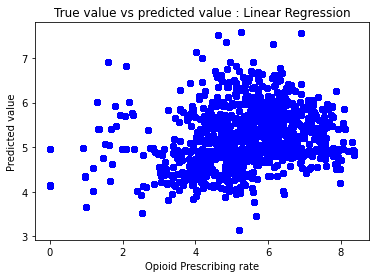

In [99]:
plt.scatter(y_test2, y_pred2, c = 'blue')
plt.xlabel("Opioid Prescribing rate")
plt.ylabel("Predicted value")
plt.title("True value vs predicted value : Linear Regression")
plt.show()

In [100]:
mse2 = mean_squared_error(y_test2, y_pred2)
print("Mean Square Error : ", mse2)

Mean Square Error :  1.6371803012244892


In [72]:
final_features3 = ['Year', 'Breakout', 'Opioid_Prscrbng_Rate_5Y_Chg','Tot_Clms',
       'Opioid_Prscrbng_Rate_1Y_Chg', 'Prscrbr_State_Abrvtn', 'total_grams',
       'contributor_aggregate_ytd']
label = 'Opioid_Prscrbng_Rate'

In [73]:
x_train3 = processed_train[final_features3]
y_train3 = processed_train[label]

In [74]:
x_train3.head()

,Year,Breakout,Opioid_Prscrbng_Rate_5Y_Chg,Tot_Clms,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
4034218,0,2,-0.91,132936548.0,-0.29,8,1.127219e+08,2.171886e+07
3910334,0,1,-1.64,6413187.0,-0.52,8,1.127219e+08,2.171886e+07
2623679,1,2,-1.74,50103515.0,-0.30,40,1.106431e+08,2.379832e+07
4780168,0,0,-1.58,34249339.0,-0.45,20,1.127219e+08,2.171886e+07
4601198,0,0,-0.34,4035698.0,-0.25,16,1.127219e+08,2.171886e+07


In [75]:
processed_test = pre_process_data(test_set, category_values)
processed_test.head()
for each in processed_test.isna().columns:
    if each == 'report_year':
        # code it with 5 meaning not available
        processed_test[each] = 5
    elif each == 'Breakout':
        processed_test[each] == 99
    else:
        processed_test[each] = processed_test[each].fillna(0)
        
x_test3 = processed_test[final_features3]
y_test3 = processed_test[label]
x_test3.head()

,Year,Breakout,Opioid_Prscrbng_Rate_5Y_Chg,Tot_Clms,Opioid_Prscrbng_Rate_1Y_Chg,Prscrbr_State_Abrvtn,total_grams,contributor_aggregate_ytd
22150784,0,2,0.0,125211671.0,0.00,8,0.0,0.0
9953596,4,0,0.0,75707853.0,-0.38,43,0.0,0.0
17680292,2,2,0.0,75562569.0,-0.43,49,0.0,0.0
16725752,2,2,0.0,86189804.0,0.04,39,0.0,0.0
22356055,0,0,0.0,100515166.0,0.00,13,0.0,0.0


In [76]:
regressor3 = LinearRegression()
regressor3.fit(x_train3, y_train3)
y_pred3 = regressor3.predict(x_test3)

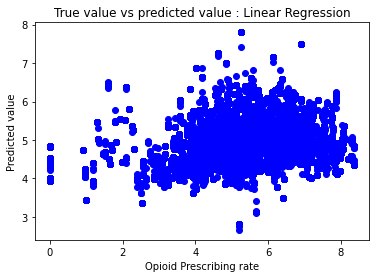

In [77]:
plt.scatter(y_test3, y_pred3, c = 'blue')
plt.xlabel("Opioid Prescribing rate")
plt.ylabel("Predicted value")
plt.title("True value vs predicted value : Linear Regression")
plt.show()

In [78]:
mse3 = mean_squared_error(y_test3, y_pred3)
print("Mean Square Error : ", mse3)

Mean Square Error :  1.7637834335402094


In [81]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report